# Setup Omero

This notebook goes through checking if Omero can connect to this project through Python. You will need the hostname, your username and password to access it.

In [23]:
!pip install omero-py

In [29]:
!pip install omero-py

In [22]:
import omero

ModuleNotFoundError: No module named 'omero'

In [1]:
!conda list

# packages in environment at /opt/anaconda3/envs/ice-test:
#
# Name                    Version                   Build  Channel
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
appnope                   0.1.3              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39h63b48b0_2    conda-forge
asttokens                 2.0.5              pyhd8ed1ab_0    conda-forge
attrs                     21.4.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.11.1             pyha770c72_0    conda-forge
bleach                    5.0.1              pyhd8ed1ab_0    conda-forge
brotlipy                  0.7.0           py39h63b48b0_1004    co

In [3]:
# Function to connect to the Omero server
# Might clean this up into a separate py file if more is added to this notebook

from omero.gateway import BlitzGateway
from getpass import getpass

# Function that connects the user to the omero server
def connect(hostname, username, password):
    """
    Connect to an OMERO server

    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(60)
    return conn

# Using the function from above
HOST = 'ome2.hpc.sussex.ac.uk' #change if different
conn = connect(HOST, input("Username: "), getpass("OMERO Password: "))
try:
    print('Connected as', conn.getUser().getName())
except AttributeError:
    print('You inputted a wrong username and/or password.')

You inputted a wrong username and/or password.


In [369]:
from segmentation.seg_functions import count_cells, get_cell_crop_coordinates, get_img_crops

#Ok so clearly the model is bad on this kind of data because it was never trained on it
#That means we'll have to remake a model on this, but right now let's just focus on making a pipeline that works and then we'll put better data into it
#Next step is to get the crops from the prediction
#Then we'll apply them on the DAPI and Cy5 image to eventually measure their pixel intensity
#Then we'll plot all of this into a graph that we'll apply k-means clustering too

print('Prediction has',count_cells(predicted_mask),'cells')
crop_coordinates = get_cell_crop_coordinates(predicted_mask)
dapi_crops = get_img_crops(dapi_img,crop_coordinates)
cy5_crops = get_img_crops(cy5_img,crop_coordinates)

Prediction has 146 cells


In [3]:
# Get a plate's images
plate_id = 812
plate = conn.getObject("Plate", plate_id)
plate_name=plate.name
print (plate_name)

Rehan_TrainingData_01


In [4]:


dapi_imgs = []
wells = list(plate.listChildren())
for i in range(len(wells)):
    print(str(i+1)+'/'+str(len(wells)))
    well = wells[i]
    for number, item in enumerate(well.listChildren()):
        image = well.getImage(number)
        pixels = image.getPrimaryPixels() #what are primary pixels?
        dapi_imgs.append(pixels.getPlane(0,0,0)) #does this get the dapi intensity of cells channel? interesting
        #print(img_dapi.shape)

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20
Execution time: 39.54001212120056 seconds


In [8]:
# Let's get well 1, image in field 1 and store that in the cell_data
# Then we'll display it

well_num = 0
field_num = 0

plate = conn.getObject("Plate", 812)
dapi_img = list(plate.listChildren())[well_num].getImage(field_num).getPrimaryPixels().getPlane(0,0,0)
cy5_img = list(plate.listChildren())[well_num].getImage(field_num).getPrimaryPixels().getPlane(0,1,0)

In [15]:
!pip install opencv-python

In [4]:
!pip install ezomero

  Using cached ezomero-1.1.0-py3-none-any.whl (44 kB)


In [5]:
import ezomero

HOST = 'ome2.hpc.sussex.ac.uk' #change if different
port=4064
conn = ezomero.connect(user='rz200',password='omeroreset',group='',host=HOST,port=4064,secure=True)
if conn: print('Connection successful')
else: print('Unsuccessful')


ERROR:root:Could not connect, check your settings


Unsuccessful


In [374]:
plate = 812
image_ids = ezomero.get_image_ids(conn,plate=plate)
print('In plate',plate,'we have',len(image_ids),'images')

In plate 812 we have 180 images


In [14]:
import numpy as np

image = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.tiff')

In [115]:
import numpy as np
image = ezomero.get_image(conn,image_id=image_ids[0]) #this gets the first image, it has 4 channels
ori_img = np.reshape(image[1],(1080,1080,4)) #full_image with 4 channels
gray_img = np.average(np.reshape(image[1],(1080,1080,4)), axis=-1) #averaged out original img
dapi_img = np.reshape(image[1],(1080,1080,4))[:,:,0] #channel 0 is DAPI
cy5_img = np.reshape(image[1],(1080,1080,4))[:,:,1] #channel 1 is Cy5

In [17]:
gray_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/gray_img.npy')
dapi_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/dapi_img.npy')
cy5_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.npy')

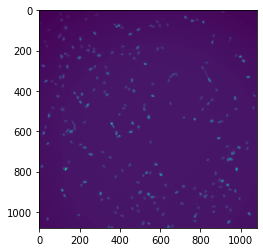

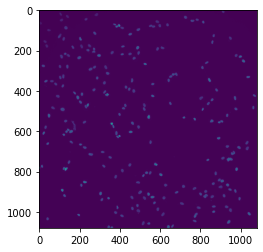

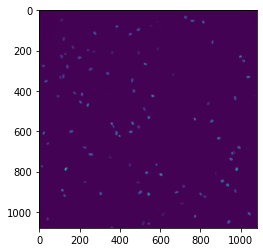

In [18]:
import matplotlib.pyplot as plt

plt.imshow(gray_img);plt.show()
plt.imshow(dapi_img);plt.show()
plt.imshow(cy5_img);plt.show()

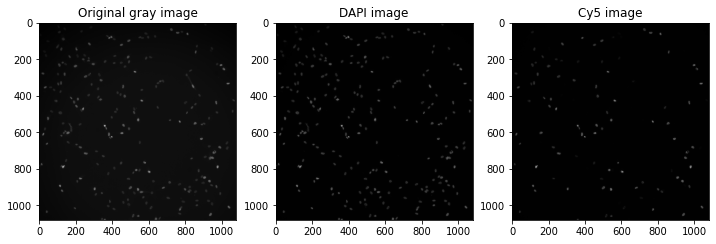

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.title('Original gray image')
plt.imshow(gray_img,cmap='gray')
plt.subplot(1,3,2)
plt.title('DAPI image')
plt.imshow(dapi_img,cmap='gray')
plt.subplot(1,3,3)
plt.title('Cy5 image')
plt.imshow(cy5_img,cmap='gray')
plt.show()

In [20]:
from segmentation.seg_functions import make_predictions, display_imgs
#Now that we have the images, we have to make the crops
#We'll get the coordinates around the gray image and then apply them on the DAPI and Cy5 images
from cellpose import io
#First we have to put the image into a directory

#images_data = io.load_train_test_data(images_dir, mask_filter='_seg.npy')[:2]  # loads the test data
predictions = make_predictions(model_dir,images_dir)
display_imgs(predictions)

ModuleNotFoundError: No module named 'cv2'

In [197]:
#Making the prediction
from cellpose import models
model_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
model = models.CellposeModel(gpu=True, pretrained_model=model_dir)
test_data = [gray_img]
predicted_test_masks = model.eval(test_data, channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions # we could use the fact that it has a channel input to have the normal image not separated by channel and just make it do the prediction on there, although we need it to make a prediction on the averaged out gray image so that wouldn't really work
predicted_mask = predicted_test_masks[0]

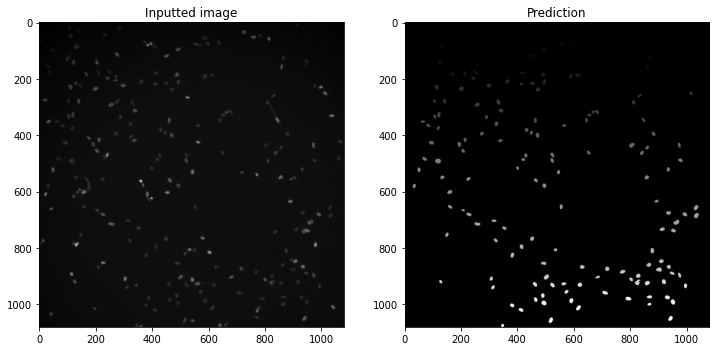

In [199]:
#Displaying the prediction
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title('Inputted image')
plt.imshow(gray_img,cmap='gray')
plt.subplot(1,2,2)
plt.title('Prediction')
plt.imshow(predicted_mask,cmap='gray')
plt.show()

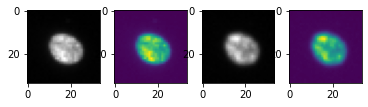

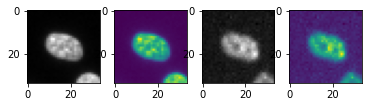

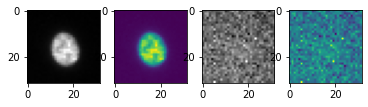

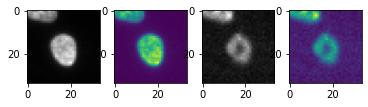

In [229]:
#Displaying the first 4 crops
for i in range(4):
    plt.subplot(1,4,1)
    plt.imshow(dapi_crops[i],cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(dapi_crops[i])
    plt.subplot(1,4,3)
    plt.imshow(cy5_crops[i],cmap='gray')
    plt.subplot(1,4,4)
    plt.imshow(cy5_crops[i])
    plt.show()

In [253]:
dapi_cy5_values = []
for i in range(len(cy5_crops)):
    dapi_avg = np.average(dapi_crops[i])
    cy5_avg = np.average(cy5_crops[i])
    dapi_cy5_values.append(np.array([dapi_avg,cy5_avg]))

dapi_cy5_values = np.array(dapi_cy5_values)

In [375]:
# Function that takes a cell image (with at least a DAPI and a Cy5 channel) and returns the DAPI and Cy5 values for each found cell in the image with its crops around each cells
# Input should be the ezomero image
def get_cell_values(image,model='demo_model'):
    # Get the model
    if model == 'demo_model':
        model_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
        model = models.CellposeModel(gpu=True, pretrained_model=model_dir)

    # Get the images
    gray_img = np.average(np.reshape(image[1],(1080,1080,4)), axis=-1) #averaged out original img
    dapi_img = np.reshape(image[1],(1080,1080,4))[:,:,0] #channel 0 is DAPI
    cy5_img = np.reshape(image[1],(1080,1080,4))[:,:,1] #channel 1 is Cy5

    # Make the prediction on the gray images

    predicted_test_masks = model.eval([gray_img], channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions
    predicted_mask = predicted_test_masks[0]

    # Get the coordinates
    crop_coordinates = get_cell_crop_coordinates(predicted_mask)

    # Get the crops
    gray_crops = get_img_crops(gray_img,crop_coordinates)
    dapi_crops = get_img_crops(dapi_img,crop_coordinates)
    cy5_crops = get_img_crops(cy5_img,crop_coordinates)

    # Get the pixel intensity measures
    dapi_cy5_values = []
    for i in range(len(dapi_crops)):
        dapi_avg = np.average(dapi_crops[i])
        cy5_avg = np.average(cy5_crops[i])
        dapi_cy5_values.append(np.array([dapi_avg,cy5_avg]))
    dapi_cy5_values = np.array(dapi_cy5_values)

    return dapi_cy5_values, gray_crops

In [377]:
# Function to apply kmeans clustering on cell DAPI and Cy5 average pixel intesities and return their labels
def get_kmeans_labels(cell_values,n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cell_values)
    return kmeans.labels_

In [378]:
# Function to display in a scatter plot the kmeans predicted classes
def display_kmeans(cell_values,labels):
    values = np.concatenate((cell_values, labels[:,None]),axis=1)
    colours = np.array(['blue' if label==0 else 'red' if label==1 else 'green' if label==2 else 'black' for label in values[:,2]])

    plt.scatter(values[:,0],values[:,1],color=colours)
    plt.xlabel('DAPI color intensity level')
    plt.ylabel('EdU (Cy5) color intensity level')
    plt.title('Cell-cycle classifying by DAPI and EdU levels')
    handles = [mpatches.Patch(color='blue', label='G1'),mpatches.Patch(color='red', label='S'),mpatches.Patch(color='green', label='G2/M')]
    plt.legend(handles=handles,title='Cycle phase',bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

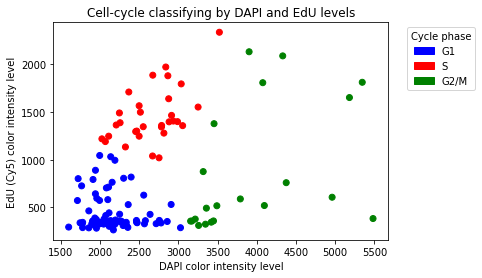

In [383]:
image = ezomero.get_image(conn,image_id=image_ids[0]) #this gets the first image, it has 4 channels
cell_values, gray_crops = get_cell_values(image)
display_kmeans(cell_values,get_kmeans_labels(cell_values))

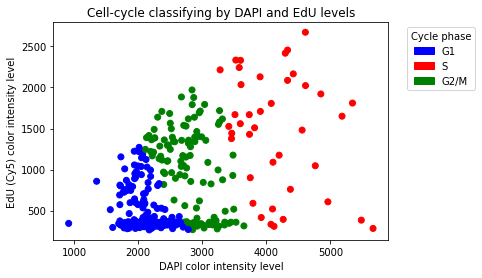

8.426276445388794


In [391]:
#Now lets apply these functions but with more data
import time
start = time.time()
image0 = ezomero.get_image(conn,image_id=image_ids[0])
image1 = ezomero.get_image(conn,image_id=image_ids[1])
cell_values0, gray_crops0 = get_cell_values(image0)
cell_values1, gray_crops1 = get_cell_values(image1)
cell_values = np.vstack((cell_values0,cell_values1))
display_kmeans(cell_values,get_kmeans_labels(cell_values))
print(time.time()-start)

In [392]:
#Now lets apply these functions but with EVEN more data (more than two images)
#It takes a little while (90s) to generate all of these images by the way
print(len(image_ids))
#get all the images in one array
#for each of these images get their cells values and vstack them onto cell_values

images = [ezomero.get_image(conn,image_id=image_id) for image_id in image_ids]

180


2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


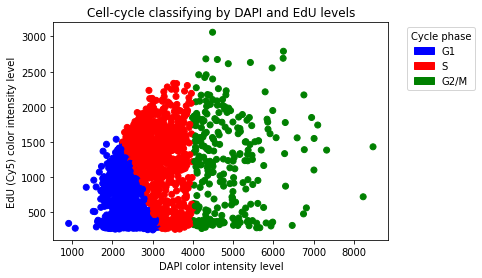

In [397]:
#just compute the first and then add the rest
#might also take a little time for this to run, it does seem to take up quite a bit of time...
cell_values, gray_crops = get_cell_values(images[0])
for i in range(1,len(images)-170): #TODO: replace this with a numpy array
    print(str(i+1)+'/'+str(len(images)-170)) #have to do -170 to only do 10 images because I don't have time right now to wait for all of the 180 images to produce data, as much as I want to do and should do tomorrow. Wow I really need to speed up these functions, it's not even the image retrieval from Omero since they have already been retrieved from the cell above
    cell_values_to_add, gray_crops = get_cell_values(images[i])
    cell_values = np.vstack((cell_values,cell_values_to_add))
display_kmeans(cell_values,get_kmeans_labels(cell_values))

#maybe the kmeans cluster is wrong because the way we measure the intensity is wrong, maybe because of how the image is displayed since we can't even see the green

In [399]:
#Let's make a bar chart of the number of cells in each phase
kmeans_labels = get_kmeans_labels(cell_values)
unique, counts = np.unique(kmeans_labels, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

[[   0 1344]
 [   1  943]
 [   2  276]]


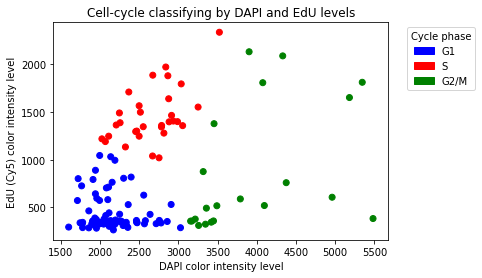

In [336]:
#put each dapi-cy5 cell value in two different arrays depending on their kmeans label
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
kmeans = KMeans(n_clusters=3, random_state=0).fit(dapi_cy5_values)
values = np.concatenate((dapi_cy5_values, np.array(kmeans.labels_)[:,None]),axis=1)
colours = np.array(['blue' if label==0 else 'red' if label==1 else 'green' if label==2 else 'black' for label in values[:,2]])

plt.scatter(values[:,0],values[:,1],color=colours)
plt.xlabel('DAPI color intensity level')
plt.ylabel('EdU (Cy5) color intensity level')
plt.title('Cell-cycle classifying by DAPI and EdU levels')
handles = [mpatches.Patch(color='blue', label='G1'),mpatches.Patch(color='red', label='S'),mpatches.Patch(color='green', label='G2/M')]
plt.legend(handles=handles,title='Cycle phase',bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

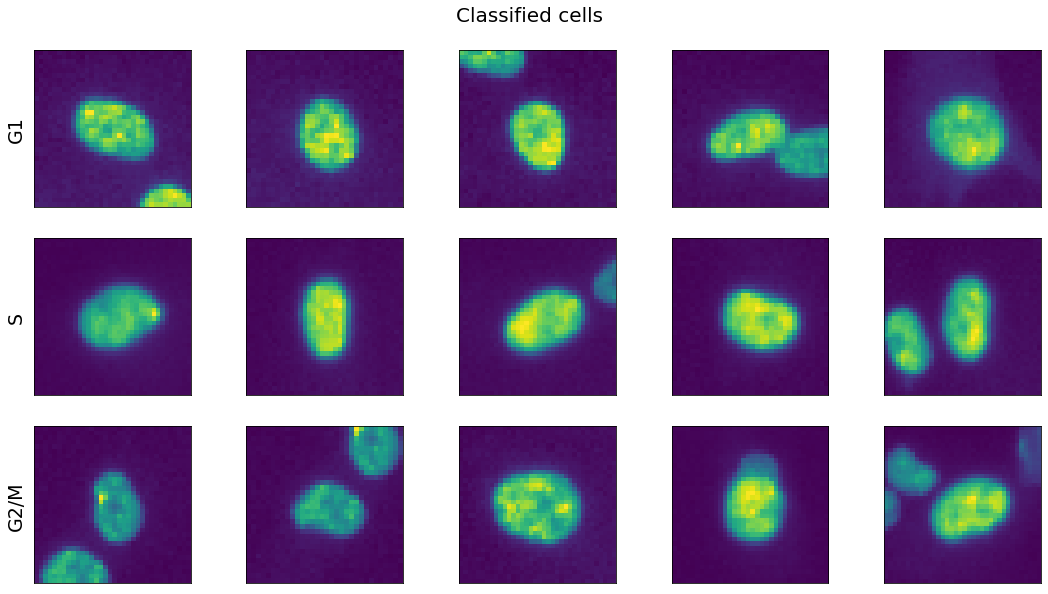

In [368]:
#Let's display the gray image of cells with their cell cycle phase name next to them
#Even better then, let's group them by their cycle phase and plot some of these
#3 rows of length 5, each row presents a cycle phase

gray_crops = get_img_crops(gray_img,crop_coordinates)

G1_crops = []
S_crops = []
G2M_crops = []
for i in range(len(gray_crops)):
    if kmeans.labels_[i] == 0: G1_crops.append(gray_crops[i])
    elif kmeans.labels_[i] == 1: S_crops.append(gray_crops[i])
    elif kmeans.labels_[i] == 2: G2M_crops.append(gray_crops[i])

#let's add at each row a
fig, ax = plt.subplots(figsize=(15,8))
fig.tight_layout()
fig.suptitle("Classified cells", y=1.05, fontsize=20)
for i in range(15):
    plt.subplot(3,5,i+1)

    #setting row titles
    if i == 0: plt.ylabel('G1',fontsize=19)
    elif i == 5: plt.ylabel('S',fontsize=19)
    elif i == 10: plt.ylabel('G2/M',fontsize=19)

    #setting the images depending on the row
    if i < 5: plt.imshow(G1_crops[i])
    elif i < 10: plt.imshow(S_crops[i])
    elif i < 15: plt.imshow(G2M_crops[i])

    plt.xticks([]),plt.yticks([])
